In [1]:
import math
import os
import gc
import re
import sys
import time
import json
import random
import datetime
import traceback
import pickle
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
plt.rcParams['font.sans-serif'] = ['Microsoft JhengHei'] 
plt.rcParams['axes.unicode_minus'] = False

import seaborn as sns
sns.set(font=['sans-serif'])
sns.set_style("whitegrid",{"font.sans-serif":['Microsoft JhengHei']})

In [2]:
train = pd.read_csv('../tmp/train/train.csv')
car_autohome_all = pd.read_csv('../tmp/train/car_autohome_all.csv')
div_price_bn_data = pd.read_csv('../tmp/train/div_price_bn_data.csv')
div_price_bn_k_param = pd.read_csv('../tmp/train/div_price_bn_k_param.csv')
global_model_mean = pd.read_csv('../tmp/train/global_model_mean.csv')
div_warehouse_data = pd.read_csv('../tmp/train/div_warehouse_data.csv')
div_warehouse_k_param = pd.read_csv('../tmp/train/div_warehouse_k_param.csv')
div_mile_data = pd.read_csv('../tmp/train/div_mile_data.csv')
div_mile_k_param = pd.read_csv('../tmp/train/div_mile_k_param.csv')
div_province_data = pd.read_csv('../tmp/train/div_province_data.csv')
div_province_k_param = pd.read_csv('../tmp/train/div_province_k_param.csv')

# global_model_mean = pd.read_csv('../tmp/train/global_model_mean.csv')

# 估值系统数据分析报告(V1.1)
## 一.指导价差拟合曲线
### 下图为上一版本指导价差拟合曲线.
### 说明:旧拟合曲线根据车龄进行分类,使用一阶曲线进行拟合.绝大部分车系能很好拟合,但个别特殊车系,或者因某些政策的支撑,会拟合不理想.

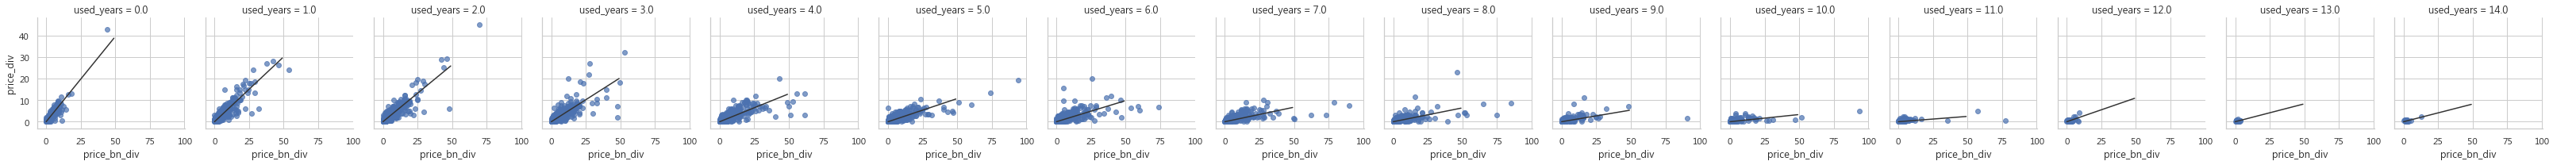

In [3]:
div_price_bn_data = div_price_bn_data.sort_values(by=['used_years'])
div_price_bn_k_param = div_price_bn_k_param.sort_values(by=['used_years'])

g = sns.FacetGrid(div_price_bn_data, col="used_years")
g.map(plt.scatter, "price_bn_div", "price_div", alpha=.7)

for i, ax in enumerate(g.axes.flat):
    k = div_price_bn_k_param.loc[i, ['k']].values
    x = range(0,50)
    y = [j*k for j in range(0, 50)]
    ax.plot(x, y, c=".2", ls="-")

g.add_legend()
# print('不合理拟合,请注意人工调整k参数.')

### 随即抽取两车系进行对比,如下图.不同年款,指导价差曲率有明显差异,但整体呈现一阶曲线.
### 下一版本升级方向:针对车系分别拟合指导价差.

车系:宝马3系


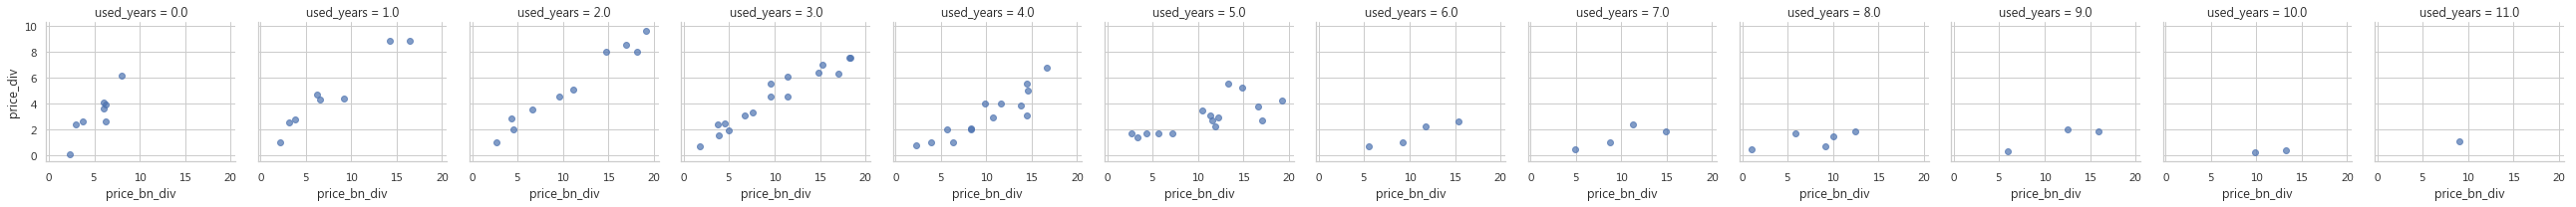

In [4]:
test = div_price_bn_data.copy()
test = test.loc[(test['model_slug'] == 66), :].reset_index(drop=True)

print('车系:宝马3系')
g = sns.FacetGrid(test, col="used_years")
g.map(plt.scatter, "price_bn_div", "price_div", alpha=.7)
plt.show()

车系:奔驰E级


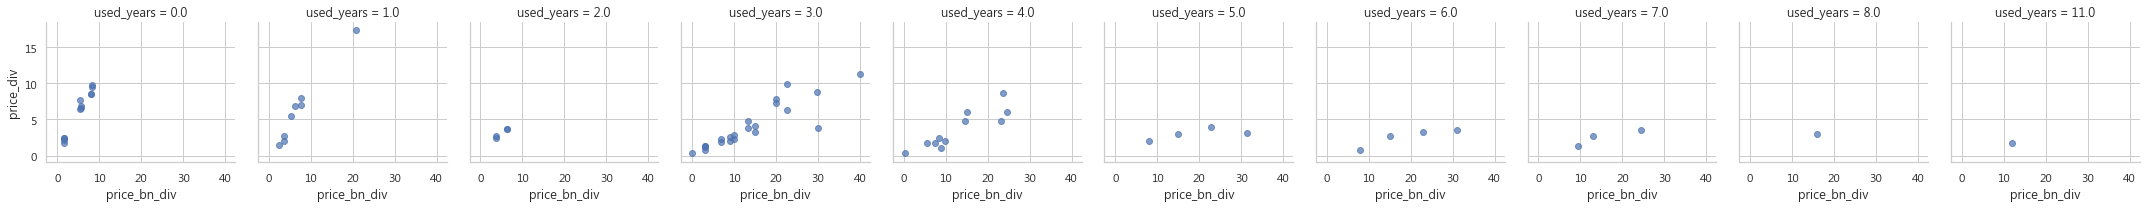

In [5]:
test = div_price_bn_data.copy()
test = test.loc[(test['model_slug'] == 197), :].reset_index(drop=True)

print('车系:奔驰E级')
g = sns.FacetGrid(test, col="used_years")
g.map(plt.scatter, "price_bn_div", "price_div", alpha=.7)
plt.show()

## 二.全国均价拟合
### 说明:均价拟合根据抓取平台车源数据,数据清洗和剔除离群点之后,得到低配保值率依年份衰减图,抽取部分车系做图如下.通过全国均价和指导价差拟合可得所有款型全国均价.
### 下一版本升级方向:需要爬虫抓取更多的可信车源数据,装填更多的数据空间,稀疏空间需要人工进行补充(关于人工评估部分车源,后续会制定周期性的工作计划)

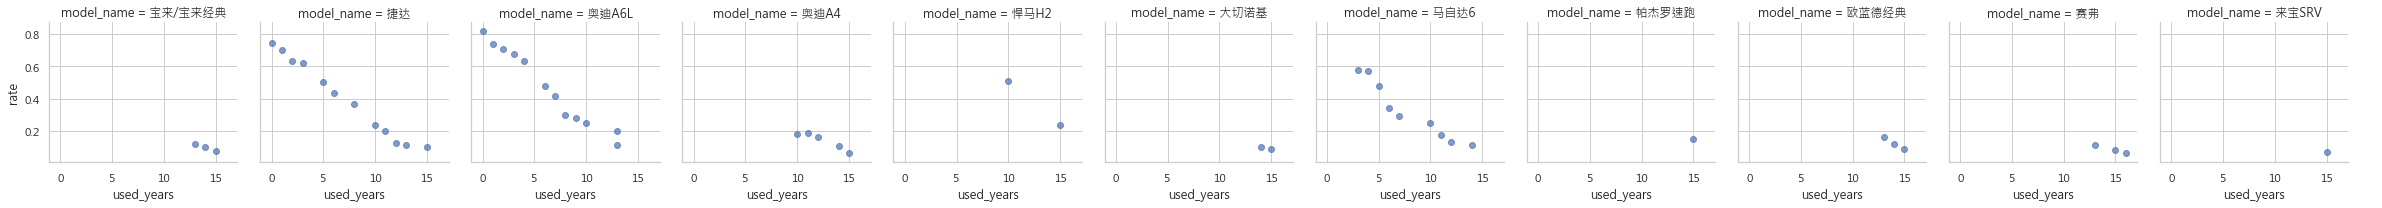

In [4]:
# 取低配数据
models = global_model_mean.loc[global_model_mean.groupby(['brand_slug', 'model_slug', 'online_year']).price_bn.idxmin(), :].reset_index(drop=True)
models['rate'] = models['median_price'] / models['price_bn']
models = models.loc[(models['model_slug'] < 40),:].reset_index(drop=True)
  
g = sns.FacetGrid(models, col="model_name")
g.map(plt.scatter, "used_years", "rate", alpha=.7)
g.add_legend()

## 三.注册年份差异拟合曲线
### 说明:根据市场调研,KBB的二手车估值只关心年款,并不关心具体的上牌时间,从国内的数据拟合来看,该特征权重也相对较小,上一版本用一阶曲线进行拟合,分类粒度交粗.根据市场调查,市场占有率高的,注册年限晚的保值率较高,市场占有率低的,注册年限晚的保值率也会提升,但是力度小.

### 后两图随即抽取两款型查看,能看出曲率明显有差异

### 升级方向:采集市场占有率特征(不一定能采集到,也可用其他组合特征代替,暂时还在思索)

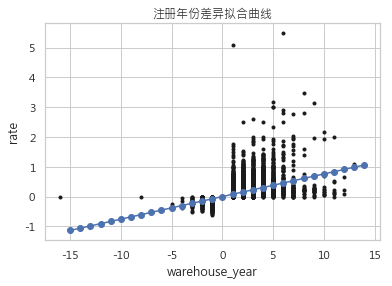

In [10]:
test = div_warehouse_data.copy()
part1 = test.loc[(test['warehouse_year'] >= 0)&(test['rate'] >= 0),:]
part2 = test.loc[(test['warehouse_year'] < 0)&(test['rate'] < 0),:]
test = part1.append(part2, sort=False).reset_index(drop=True)

plt.figure()
plt.title(u'注册年份差异拟合曲线')
plt.xlabel(u'warehouse_year')
plt.ylabel(u'rate')
plt.grid(True)
x = list(test.warehouse_year.values)
y = list(test.rate.values)
plt.plot(x, y, 'k.')

k = div_warehouse_k_param.loc[0, 'k']
x = range(-15,15)
y = [k * i for i in range(-15,15)]
plt.plot(x, y, 'o-')

随即抽取一款型查看


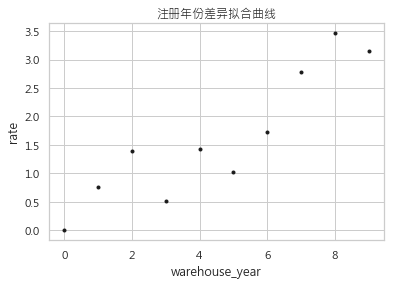

In [17]:
test = div_warehouse_data.copy()
part1 = test.loc[(test['warehouse_year'] >= 0)&(test['rate'] >= 0),:]
part2 = test.loc[(test['warehouse_year'] < 0)&(test['rate'] < 0),:]
test = part1.append(part2, sort=False).reset_index(drop=True)
test = test.loc[(test['detail_slug'] == 6775), :].reset_index(drop=True)

print('随即抽取一款型查看')
plt.figure()
plt.title(u'注册年份差异拟合曲线')
plt.xlabel(u'warehouse_year')
plt.ylabel(u'rate')
plt.grid(True)
x = list(test.warehouse_year.values)
y = list(test.rate.values)
plt.plot(x, y, 'k.')

随即抽取一款型查看


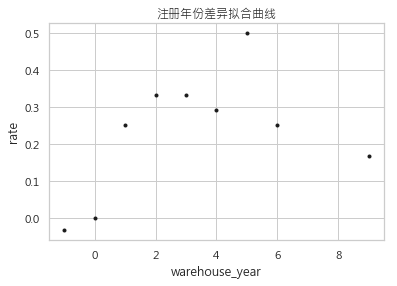

In [16]:
test = div_warehouse_data.copy()
part1 = test.loc[(test['warehouse_year'] >= 0)&(test['rate'] >= 0),:]
part2 = test.loc[(test['warehouse_year'] < 0)&(test['rate'] < 0),:]
test = part1.append(part2, sort=False).reset_index(drop=True)
test = test.loc[(test['detail_slug'] == 1000712.0), :].reset_index(drop=True)

print('随即抽取一款型查看')
plt.figure()
plt.title(u'注册年份差异拟合曲线')
plt.xlabel(u'warehouse_year')
plt.ylabel(u'rate')
plt.grid(True)
x = list(test.warehouse_year.values)
y = list(test.rate.values)
plt.plot(x, y, 'k.')

## 四.公里数拟合

### 说明:根据市场调查,公里数只要在合理范围内对价格的影响非常小,几乎可以忽略不计,因为可以调整公里表,只是在收车时对公里数太高的压价.所以我们只要在估值时表现出随公里数增加合理衰减即可.沿用上一版本拟合.

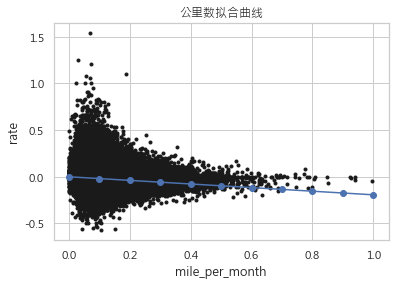

In [19]:
plt.figure()
plt.title(u'公里数拟合曲线')
plt.xlabel(u'mile_per_month')
plt.ylabel(u'rate')
plt.grid(True)
x = list(div_mile_data.mile_per_month.values)
y = list(div_mile_data.rate.values)
plt.plot(x, y, 'k.', )

k, b = div_mile_k_param.loc[0, ['k','b']].values
x = [i*0.1 for i in range(0,11)]
y = [k * i for i in x]
plt.plot(x, y, 'o-')

## 五.省份差异拟合
### 说明:之前拟合效果较差,看不出明显模式.省份价格和全国均价方差很大.

### 升级方向:根据市场调查,市场占有率高的保值率偏高,所以还是需要将车系细分到各省份的市场占有率,采集市场占有率相关数据.并组合一二三线等城市进行调整。

不合理拟合,请注意人工调整k参数.


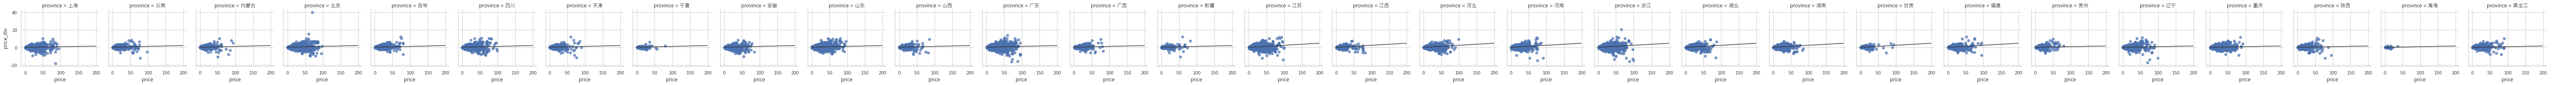

In [22]:
div_province_k_param = div_province_k_param.loc[(div_province_k_param['province'].isin(list(set(div_province_data.province.values)))), :]
div_province_data = div_province_data.sort_values(by=['province'])
div_province_k_param = div_province_k_param.sort_values(by=['province'])

g = sns.FacetGrid(div_province_data, col="province")
g.map(plt.scatter, "price", "price_div", alpha=.7)

for i, ax in enumerate(g.axes.flat):
    k, b = div_province_k_param.loc[i, ['k','b']].values
    x = range(0,200)
    y = [j*k+b for j in range(0, 200)]
    ax.plot(x, y, c=".2", ls="-")

g.add_legend()
print('不合理拟合,请注意人工调整k参数.')

## 六.零售价与收购价拟合
### 说明:上一版本人工搜集了一批收购价,拟合零售价与收购价呈现指数衰减曲线.分类力度依然太粗.

### 升级方向:需要爬虫采集收购价数据,根据市场调查,市场占有率高的零售价与收购价比率交低,占有率低的比率较高,所以还需要细分拟合曲线.

[2.341805806147327, 0.3148107398400336, 2.288486168614544, 2.0844290831908747, 1.6074359097634274, 2.2679936482244267, 3.40552135314221]
0.34 -0.599


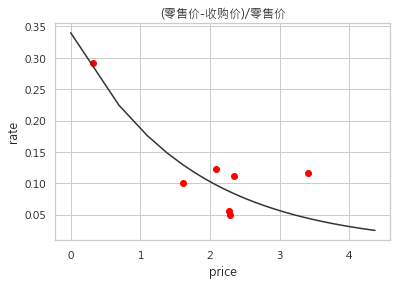

In [36]:
import math
def cal_newton_min_param(x, y):
    """
    牛顿k参数
    """
    k = 0
    count = 0
    result = pd.DataFrame([],columns=['c','k','sum_div'])
    for j in range(1, 1000):
        c = j*0.01
        temp = float("inf")
        for step in range(0, 1000):
            k = -step * 0.01
            div = 0
            for i in range(0, len(x)):
                div = div + (c * math.e ** (k * x[i]) - y[i]) ** 2
            if temp < div:
                break 
            else:
                temp = div
        result.loc[count, ['c','k','sum_div']] = c, k+0.001, div
        count = count + 1
    min_div = min(list(set(result.sum_div.values)))
    return result.loc[(result['sum_div'] == min_div), ['c','k']].values[0]

plt.figure()
plt.title('(零售价-收购价)/零售价')
plt.xlabel(u'price')
plt.ylabel(u'rate')
plt.grid(True)
x = [10.4,1.37,9.86,8.04,4.99,9.66,30.13]
x = [math.log(i,math.e) for i in x]
print(x)
y = [0.112,0.292,0.05,0.123,0.10,0.056,0.117]
plt.plot(x, y, 'bo', color='red')
c, k = cal_newton_min_param(x, y)
print(c, k)
# print(c * math.e ** (k * 8.8) + 0.08)
# x = range(0,80) * 0.01
# y = [c * math.e ** (k * i)+0.08 for i in range(0,80)]
x = [math.log(i,math.e) for i in range(1,80)]
y = [c * math.e ** (k * math.log(i,math.e)) for i in range(1,80)]
plt.plot(x, y, c=".2", ls="-")

## 下一轮版本升级总结:
### 爬虫工作:1.完成未做完工作并形成周期抓取(瓜子,人人车); 2.新增收购价抓取(暂定天天拍,调研后再定); 3.新增市场占有率特征抓取(调研后再定)
### 算法工作:1.根据数据分析细分相关特征并进行拟合; 2.完善与爬虫的衔接工作; 3.完善与估值相关系统的衔接工作